In [ ]:
"""
DeepLabV3 on Image Processed Dataset

Author: Nelson Nishio
Date: 07-22-2025
Last Updated: 07-22-2025
"""

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import json
import os
import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as A
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Configuration
class Config:
    IMAGE_HEIGHT = 512
    IMAGE_WIDTH = 512
    NUM_CLASSES = 2  # background + building
    BATCH_SIZE = 4
    EPOCHS = 50
    LEARNING_RATE = 1e-4
    IMAGES_DIR = "/content/drive/MyDrive/Autonomous Drone/Building Dataset/Combined Data_CLAHE_LoG"  # Directory containing building images
    ANNOTATIONS_FILE = "/content/drive/MyDrive/Autonomous Drone/Building Dataset/training_data_207.json"  # VIA annotation file
    MODEL_SAVE_PATH = "/content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5"
    VALIDATION_SPLIT = 0.2

config = Config()

def load_via_annotations(annotations_file):
    """Load VIA annotations from JSON file"""
    with open(annotations_file, 'r') as f:
        annotations = json.load(f)
    return annotations

def polygon_to_mask(polygon_points, image_shape):
    """Convert polygon points to binary mask"""
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    if len(polygon_points) > 0:
        # Convert to format expected by fillPoly
        pts = np.array(polygon_points, dtype=np.int32)
        cv2.fillPoly(mask, [pts], 1)
    return mask

def parse_via_annotations(annotations, images_dir):
    """Parse VIA annotations and create image-mask pairs"""
    image_paths = []
    mask_data = []

    # Check if the annotations have the VIA metadata structure
    if '_via_img_metadata' in annotations:
        img_metadata = annotations['_via_img_metadata']

        for img_id, img_data in img_metadata.items():
            if 'filename' in img_data:
                filename = img_data['filename']
                image_path = os.path.join(images_dir, filename)

                if os.path.exists(image_path):
                    # Load image to get dimensions
                    image = cv2.imread(image_path)
                    if image is None:
                        print(f"Warning: Could not load image {image_path}")
                        continue

                    height, width = image.shape[:2]

                    # Create mask from polygons
                    mask = np.zeros((height, width), dtype=np.uint8)

                    if 'regions' in img_data:
                        for region in img_data['regions']:
                            if 'shape_attributes' in region:
                                shape_attrs = region['shape_attributes']
                                if shape_attrs['name'] == 'polygon':
                                    # Extract polygon points
                                    x_points = shape_attrs['all_points_x']
                                    y_points = shape_attrs['all_points_y']

                                    polygon_points = list(zip(x_points, y_points))
                                    region_mask = polygon_to_mask(polygon_points, (height, width))
                                    mask = np.maximum(mask, region_mask)
                                elif shape_attrs['name'] == 'rect':
                                    x = shape_attrs['x']
                                    y = shape_attrs['y']
                                    w = shape_attrs['width']
                                    h = shape_attrs['height']

                                    top_left = (x, y)
                                    bottom_right = (x + w, y + h)

                                    cv2.rectangle(mask, top_left, bottom_right, color=1, thickness=-1)

                                else:
                                    print(f"Warning: Unsupported shape type: {shape_attrs['name']}")

                    image_paths.append(image_path)
                    mask_data.append(mask)
                    print(f"Processed: {filename} with {len(img_data.get('regions', []))} regions")
                else:
                    print(f"Warning: Image not found at {image_path}")
    else:
        print("Error: Invalid VIA annotations format")

    return image_paths, mask_data

def create_augmentation_pipeline():
    """Create augmentation pipeline"""
    return A.Compose([
        # Remove RandomResizedCrop since we're handling aspect ratio with padding
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.RandomGamma(p=0.2),
        A.GaussNoise(p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.3),
    ])

def resize_with_padding(image, mask, target_size):
    """Resize image and mask with padding to maintain aspect ratio"""
    h, w = image.shape[:2]
    target_h, target_w = target_size

    # Calculate scaling factor to fit the image within target size
    scale = min(target_w / w, target_h / h)

    # Calculate new dimensions
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Resize image and mask
    image_resized = cv2.resize(image, (new_w, new_h))
    mask_resized = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    # Calculate padding
    pad_w = target_w - new_w
    pad_h = target_h - new_h

    # Pad evenly on both sides
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    # Apply padding
    image_padded = cv2.copyMakeBorder(
        image_resized, pad_top, pad_bottom, pad_left, pad_right,
        cv2.BORDER_CONSTANT, value=[0, 0, 0]  # Black padding
    )

    mask_padded = cv2.copyMakeBorder(
        mask_resized, pad_top, pad_bottom, pad_left, pad_right,
        cv2.BORDER_CONSTANT, value=0  # Background class padding
    )

    return image_padded, mask_padded

def preprocess_image(image_path, mask, augment=False):
    """Preprocess image and mask"""
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize with padding to maintain aspect ratio
    image, mask = resize_with_padding(image, mask, (config.IMAGE_HEIGHT, config.IMAGE_WIDTH))

    # Apply augmentations
    if augment:
        aug_pipeline = create_augmentation_pipeline()
        augmented = aug_pipeline(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']

    # Normalize image
    image = image.astype(np.float32) / 255.0

    # Convert mask to categorical
    mask = tf.keras.utils.to_categorical(mask, num_classes=config.NUM_CLASSES)

    return image, mask

class DataGenerator(tf.keras.utils.Sequence):
    """Data generator for training"""
    def __init__(self, image_paths, masks, batch_size, augment=False):
        self.image_paths = image_paths
        self.masks = masks
        self.batch_size = batch_size
        self.augment = augment
        self.indices = np.arange(len(image_paths))

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_masks = []

        for i in batch_indices:
            image, mask = preprocess_image(self.image_paths[i], self.masks[i], self.augment)
            batch_images.append(image)
            batch_masks.append(mask)

        return np.array(batch_images), np.array(batch_masks)

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

def aspp_block(x, filters, rate):
    """Atrous Spatial Pyramid Pooling block"""
    # 1x1 convolution
    x1 = Conv2D(filters, 1, padding='same', activation='relu')(x)

    # 3x3 convolution with different dilation rates
    x2 = Conv2D(filters, 3, padding='same', dilation_rate=rate, activation='relu')(x)

    return x2


In [ ]:
# Load Data

print("Loading annotations...")
annotations = load_via_annotations(config.ANNOTATIONS_FILE)

print("Parsing annotations...")

image_paths, masks = parse_via_annotations(annotations, config.IMAGES_DIR)

print(f"Found {len(image_paths)} images with annotations")


Loading annotations...
Parsing annotations...
Processed: 0321mariagstfrancis2.jpg with 1 regions
Processed: 03a_CO_UCLA-La-Kretz_Photo-KimRodgers_15.jpg with 1 regions
Processed: 1.2904_S_Washington_St__Seattle_Large-7HHaug_gao9km.jpg with 1 regions
Processed: 20191209_OldOrangeCoCourthouseSantaAnaCA2.jpg with 1 regions
Processed: 20200625-3.jpg with 1 regions
Processed: 25344_7_0.jpg with 1 regions
Processed: 360_F_256694284_XkhQFaJ42Y64iEcqmHsjAGvSfdlA6K2T.jpg with 1 regions
Processed: 400IS_1200x600.jpg with 1 regions
Processed: 4378.jpg with 1 regions
Processed: 50-story-tower-just-approved-for-downtown-los-angeles-v0-pcjhcoa9zc9d1.jpg with 1 regions
Processed: 5601Fishers.jpg with 1 regions
Processed: 8383041759_82f1d321d0_b.jpg with 1 regions
Processed: 84f6eb4bb591b212911d8e8dbbbb4fcce-f3588052721rd-w480_h360.jpg with 1 regions
Processed: 888-N-Main-St-Santa-Ana-CA-Building-1-HighDefinition-1.jpg with 1 regions
Processed: 8e6407ec06a346b4b515022267f0f051e-f2132370260rd-w480_h360

Image 0: /content/drive/MyDrive/Autonomous Drone/Building Dataset/Combined Data_CLAHE_LoG/0321mariagstfrancis2.jpg
Image 1: /content/drive/MyDrive/Autonomous Drone/Building Dataset/Combined Data_CLAHE_LoG/03a_CO_UCLA-La-Kretz_Photo-KimRodgers_15.jpg
Image 2: /content/drive/MyDrive/Autonomous Drone/Building Dataset/Combined Data_CLAHE_LoG/1.2904_S_Washington_St__Seattle_Large-7HHaug_gao9km.jpg
Image 3: /content/drive/MyDrive/Autonomous Drone/Building Dataset/Combined Data_CLAHE_LoG/20191209_OldOrangeCoCourthouseSantaAnaCA2.jpg
Image 4: /content/drive/MyDrive/Autonomous Drone/Building Dataset/Combined Data_CLAHE_LoG/20200625-3.jpg


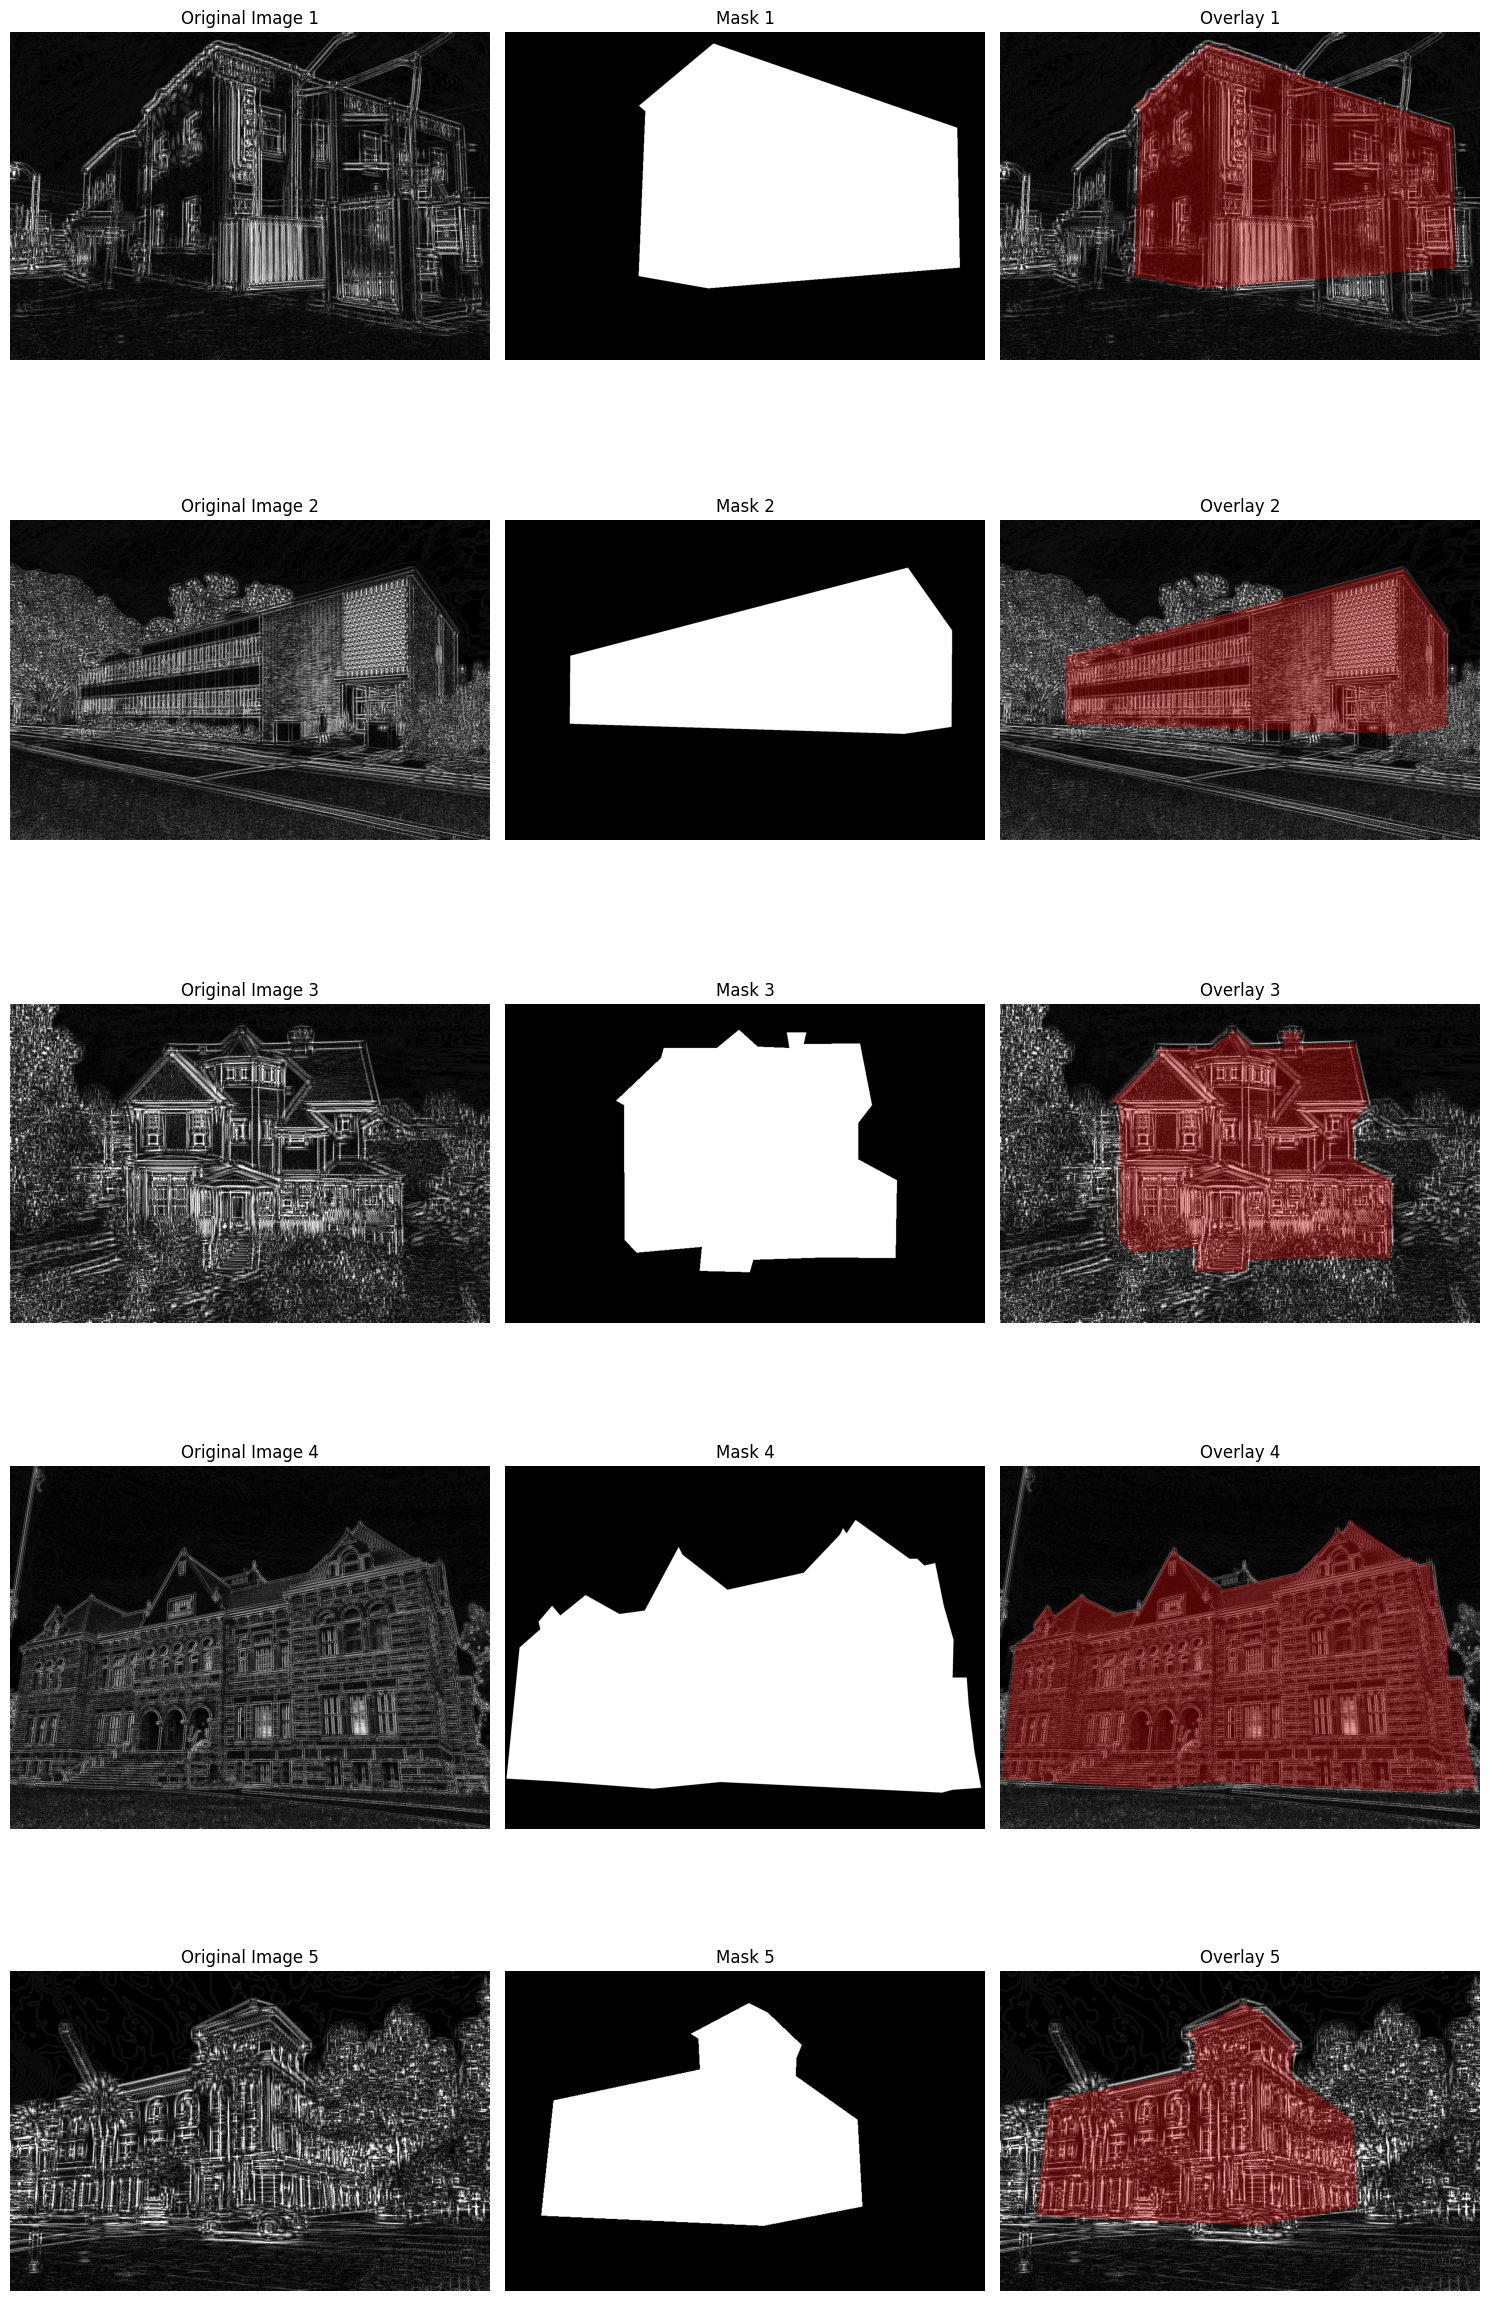

In [ ]:
def visualize_masks(image_paths, mask_data, num_samples=3):
    """Visualize original images with their corresponding masks"""
    num_samples = min(num_samples, len(image_paths))

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        # Load and convert image from BGR to RGB
        print(f"Image {i}: {image_paths[i]}")
        image = cv2.imread(image_paths[i])
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = mask_data[i]

        # Create overlay
        overlay = image_rgb.copy()
        overlay[mask > 0] = [255, 0, 0]  # Red color for masked regions
        blended = cv2.addWeighted(image_rgb, 0.7, overlay, 0.3, 0)

        # Plot original image
        axes[i, 0].imshow(image_rgb)
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')

        # Plot mask
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f'Mask {i+1}')
        axes[i, 1].axis('off')

        # Plot overlay
        axes[i, 2].imshow(blended)
        axes[i, 2].set_title(f'Overlay {i+1}')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

visualize_masks(image_paths, masks, num_samples=5)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.saving import register_keras_serializable

@register_keras_serializable()
def resize_tensor(inputs):
    tensor_to_resize, reference_tensor = inputs
    # Cast to float32 to ensure consistency
    tensor_to_resize = tf.cast(tensor_to_resize, tf.float32)
    reference_shape = tf.shape(reference_tensor)[1:3]
    # return tf.image.resize(tensor_to_resize, reference_shape)
    return tf.image.resize(tensor_to_resize, reference_shape)

# Set default dtype to float32 at the beginning
tf.keras.backend.set_floatx('float32')

def aspp_block(inputs, filters, rate):
    """ASPP block for DeepLabV3"""
    if rate == 1:
        conv = Conv2D(filters, 1, padding='same', activation='relu', dtype='float32')(inputs)
    else:
        conv = Conv2D(filters, 3, padding='same', dilation_rate=rate, activation='relu', dtype='float32')(inputs)
    conv = BatchNormalization(dtype='float32')(conv)
    return conv

def create_deeplabv3_model(input_shape, num_classes):
    """Create DeepLabV3 model"""
    # Ensure input tensor is float32
    inputs = Input(shape=input_shape, dtype='float32')

    # Backbone - ResNet50
    backbone = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # Get features from different stages
    low_level_features = backbone.get_layer('conv2_block3_out').output  # 1/4 resolution
    high_level_features = backbone.output  # 1/32 resolution

    # ASPP (Atrous Spatial Pyramid Pooling)
    aspp1 = aspp_block(high_level_features, 256, 1)
    aspp2 = aspp_block(high_level_features, 256, 6)
    aspp3 = aspp_block(high_level_features, 256, 12)
    aspp4 = aspp_block(high_level_features, 256, 18)

    # Global Average Pooling
    gap = GlobalAveragePooling2D(dtype='float32')(high_level_features)
    gap = Reshape((1, 1, 2048))(gap)
    gap = Conv2D(256, 1, activation='relu', dtype='float32')(gap)

    # Get the actual shape of high_level_features for upsampling

    gap = Lambda(resize_tensor)([gap, high_level_features])

    # Concatenate ASPP features
    aspp_concat = Concatenate()([aspp1, aspp2, aspp3, aspp4, gap])
    aspp_concat = Conv2D(256, 1, activation='relu', dtype='float32')(aspp_concat)
    aspp_concat = BatchNormalization(dtype='float32')(aspp_concat)
    aspp_concat = Dropout(0.1)(aspp_concat)

    # Upsample ASPP output to match low-level features size
    # Low-level features are at 1/4 resolution, high-level at 1/32, so we need 8x upsampling
    decoder_output = UpSampling2D(size=(8, 8), interpolation='bilinear')(aspp_concat)

    # Process low-level features
    low_level_features = Conv2D(48, 1, activation='relu', dtype='float32')(low_level_features)
    low_level_features = BatchNormalization(dtype='float32')(low_level_features)

    # Ensure both tensors have the same spatial dimensions before concatenation
    decoder_output = Lambda(resize_tensor)([decoder_output, low_level_features])

    # Concatenate with low-level features
    decoder_concat = Concatenate()([decoder_output, low_level_features])
    decoder_concat = Conv2D(256, 3, padding='same', activation='relu', dtype='float32')(decoder_concat)
    decoder_concat = BatchNormalization(dtype='float32')(decoder_concat)
    decoder_concat = Dropout(0.1)(decoder_concat)

    decoder_concat = Conv2D(256, 3, padding='same', activation='relu', dtype='float32')(decoder_concat)
    decoder_concat = BatchNormalization(dtype='float32')(decoder_concat)
    decoder_concat = Dropout(0.1)(decoder_concat)

    # Final upsampling to original resolution (4x upsampling from 1/4 resolution)
    outputs = UpSampling2D(size=(4, 4), interpolation='bilinear')(decoder_concat)
    outputs = Conv2D(num_classes, 1, activation='softmax', dtype='float32')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model


def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Dice coefficient for segmentation"""
    # Ensure both tensors are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """Dice loss for segmentation"""
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    """Combined loss: Categorical crossentropy + Dice loss"""
    # Ensure both tensors are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    dice_loss_val = dice_loss(y_true, y_pred)
    return ce_loss + dice_loss_val

def iou_score(y_true, y_pred):
    """IoU score for segmentation"""
    # Ensure both tensors are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return intersection / (union + 1e-6)


# Train Model

In [ ]:

# Split data
train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, masks, test_size=config.VALIDATION_SPLIT, random_state=42
)

print(f"Training samples: {len(train_images)}")
print(f"Validation samples: {len(val_images)}")

# Create data generators
train_generator = DataGenerator(train_images, train_masks, config.BATCH_SIZE, augment=True)
val_generator = DataGenerator(val_images, val_masks, config.BATCH_SIZE, augment=False)

# Create model
print("Creating DeepLabV3 model...")
model = create_deeplabv3_model(
    (config.IMAGE_HEIGHT, config.IMAGE_WIDTH, 3),
    config.NUM_CLASSES
)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=config.LEARNING_RATE),
    loss=combined_loss,
    metrics=['accuracy', dice_coefficient, iou_score]
)

# Callbacks
callbacks = [
    ModelCheckpoint(
        config.MODEL_SAVE_PATH,
        monitor='val_dice_coefficient',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_dice_coefficient',
        patience=15,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_dice_coefficient',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        mode='max',
        verbose=1
    )
]

# Train model
print("Starting training...")
history = model.fit(
    train_generator,
    epochs=config.EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)


Training samples: 165
Validation samples: 42
Creating DeepLabV3 model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Starting training...
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.7781 - dice_coefficient: 0.7343 - iou_score: 0.5913 - loss: 0.8778
Epoch 1: val_dice_coefficient improved from -inf to 0.62781, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.7798 - dice_coefficient: 0.7359 - iou_score: 0.5934 - loss: 0.8728 - val_accuracy: 0.7796 - val_dice_coefficient: 0.6278 - val_iou_score: 0.4576 - val_loss: 0.9258 - learning_rate: 1.0000e-04
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.9054 - dice_coefficient: 0.8775 - iou_score: 0.7824 - loss: 0.4067
Epoch 2: val_dice_coefficient did not improve from 0.62781
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 658ms/step - accuracy: 0.9054 - dice_coefficient: 0.8775 - iou_score: 0.7824 - loss: 0.4067 - val_accuracy: 0.5363 - val_dice_coefficient: 0.4989 - val_iou_score: 0.3325 - val_loss: 1.9393 - learning_rate: 1.0000e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.9276 - dice_coefficient: 0.9016 - iou_score: 0.8213 - loss: 0.2992
Epoch 3: val_dice_coefficient improved from 0.62781 to 0.73631, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 895ms/step - accuracy: 0.9277 - dice_coefficient: 0.9016 - iou_score: 0.8214 - loss: 0.2990 - val_accuracy: 0.7620 - val_dice_coefficient: 0.7363 - val_iou_score: 0.5842 - val_loss: 1.0220 - learning_rate: 1.0000e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.9310 - dice_coefficient: 0.9110 - iou_score: 0.8372 - loss: 0.2787
Epoch 4: val_dice_coefficient improved from 0.73631 to 0.75504, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9312 - dice_coefficient: 0.9111 - iou_score: 0.8374 - loss: 0.2782 - val_accuracy: 0.7627 - val_dice_coefficient: 0.7550 - val_iou_score: 0.6100 - val_loss: 1.1600 - learning_rate: 1.0000e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.9451 - dice_coefficient: 0.9265 - iou_score: 0.8635 - loss: 0.2228
Epoch 5: val_dice_coefficient improved from 0.75504 to 0.75676, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9451 - dice_coefficient: 0.9265 - iou_score: 0.8634 - loss: 0.2229 - val_accuracy: 0.7663 - val_dice_coefficient: 0.7568 - val_iou_score: 0.6104 - val_loss: 1.0894 - learning_rate: 1.0000e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.9525 - dice_coefficient: 0.9326 - iou_score: 0.8741 - loss: 0.1971
Epoch 6: val_dice_coefficient improved from 0.75676 to 0.76371, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 75s 884ms/step - accuracy: 0.9524 - dice_coefficient: 0.9326 - iou_score: 0.8741 - loss: 0.1972 - val_accuracy: 0.7643 - val_dice_coefficient: 0.7637 - val_iou_score: 0.6211 - val_loss: 1.3284 - learning_rate: 1.0000e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.9586 - dice_coefficient: 0.9442 - iou_score: 0.8947 - loss: 0.1698
Epoch 7: val_dice_coefficient improved from 0.76371 to 0.76695, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9584 - dice_coefficient: 0.9440 - iou_score: 0.8943 - loss: 0.1705 - val_accuracy: 0.7640 - val_dice_coefficient: 0.7669 - val_iou_score: 0.6243 - val_loss: 0.9927 - learning_rate: 1.0000e-04
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.9562 - dice_coefficient: 0.9376 - iou_score: 0.8830 - loss: 0.1857
Epoch 8: val_dice_coefficient did not improve from 0.76695
41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 915ms/step - accuracy: 0.9562 - dice_coefficient: 0.9377 - iou_score: 0.8830 - loss: 0.1856 - val_accuracy: 0.7691 - val_dice_coefficient: 0.7657 - val_iou_score: 0.6225 - val_loss: 1.1107 - learning_rate: 1.0000e-04
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.9586 - dice_coefficient: 0.9441 - iou_score: 0.8943 - loss: 0.1659
Epoch 9: val_dice_coefficient did not improve from 0.76695
41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 642ms/step - accuracy: 0.9586 - dice_coefficient: 0.9441 - iou_score: 0.8943 - loss: 0.1660 

41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 874ms/step - accuracy: 0.9688 - dice_coefficient: 0.9557 - iou_score: 0.9153 - loss: 0.1330 - val_accuracy: 0.7927 - val_dice_coefficient: 0.7933 - val_iou_score: 0.6585 - val_loss: 0.9132 - learning_rate: 1.0000e-04
Epoch 13/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.9700 - dice_coefficient: 0.9580 - iou_score: 0.9197 - loss: 0.1254
Epoch 13: val_dice_coefficient improved from 0.79325 to 0.79397, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9699 - dice_coefficient: 0.9579 - iou_score: 0.9196 - loss: 0.1256 - val_accuracy: 0.8096 - val_dice_coefficient: 0.7940 - val_iou_score: 0.6599 - val_loss: 0.7268 - learning_rate: 1.0000e-04
Epoch 14/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.9719 - dice_coefficient: 0.9584 - iou_score: 0.9202 - loss: 0.1215
Epoch 14: val_dice_coefficient improved from 0.79397 to 0.82753, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 981ms/step - accuracy: 0.9719 - dice_coefficient: 0.9584 - iou_score: 0.9203 - loss: 0.1214 - val_accuracy: 0.8400 - val_dice_coefficient: 0.8275 - val_iou_score: 0.7074 - val_loss: 0.6017 - learning_rate: 1.0000e-04
Epoch 15/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.9718 - dice_coefficient: 0.9620 - iou_score: 0.9270 - loss: 0.1118
Epoch 15: val_dice_coefficient improved from 0.82753 to 0.84328, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9718 - dice_coefficient: 0.9619 - iou_score: 0.9269 - loss: 0.1120 - val_accuracy: 0.8614 - val_dice_coefficient: 0.8433 - val_iou_score: 0.7304 - val_loss: 0.5183 - learning_rate: 1.0000e-04
Epoch 16/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.9757 - dice_coefficient: 0.9652 - iou_score: 0.9328 - loss: 0.0990
Epoch 16: val_dice_coefficient improved from 0.84328 to 0.86950, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 956ms/step - accuracy: 0.9757 - dice_coefficient: 0.9652 - iou_score: 0.9328 - loss: 0.0991 - val_accuracy: 0.8774 - val_dice_coefficient: 0.8695 - val_iou_score: 0.7699 - val_loss: 0.4674 - learning_rate: 1.0000e-04
Epoch 17/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.9749 - dice_coefficient: 0.9656 - iou_score: 0.9338 - loss: 0.1025
Epoch 17: val_dice_coefficient improved from 0.86950 to 0.88197, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 996ms/step - accuracy: 0.9749 - dice_coefficient: 0.9656 - iou_score: 0.9338 - loss: 0.1025 - val_accuracy: 0.8936 - val_dice_coefficient: 0.8820 - val_iou_score: 0.7896 - val_loss: 0.3846 - learning_rate: 1.0000e-04
Epoch 18/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.9734 - dice_coefficient: 0.9629 - iou_score: 0.9286 - loss: 0.1088
Epoch 18: val_dice_coefficient improved from 0.88197 to 0.88687, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 971ms/step - accuracy: 0.9734 - dice_coefficient: 0.9629 - iou_score: 0.9286 - loss: 0.1087 - val_accuracy: 0.9024 - val_dice_coefficient: 0.8869 - val_iou_score: 0.7975 - val_loss: 0.3636 - learning_rate: 1.0000e-04
Epoch 19/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.9780 - dice_coefficient: 0.9702 - iou_score: 0.9423 - loss: 0.0874
Epoch 19: val_dice_coefficient did not improve from 0.88687
41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 889ms/step - accuracy: 0.9780 - dice_coefficient: 0.9702 - iou_score: 0.9422 - loss: 0.0875 - val_accuracy: 0.8939 - val_dice_coefficient: 0.8836 - val_iou_score: 0.7926 - val_loss: 0.3932 - learning_rate: 1.0000e-04
Epoch 20/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9772 - dice_coefficient: 0.9686 - iou_score: 0.9392 - loss: 0.0912
Epoch 20: val_dice_coefficient improved from 0.88687 to 0.90043, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 794ms/step - accuracy: 0.9771 - dice_coefficient: 0.9685 - iou_score: 0.9392 - loss: 0.0914 - val_accuracy: 0.9120 - val_dice_coefficient: 0.9004 - val_iou_score: 0.8191 - val_loss: 0.3493 - learning_rate: 1.0000e-04
Epoch 21/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.9778 - dice_coefficient: 0.9693 - iou_score: 0.9405 - loss: 0.0924
Epoch 21: val_dice_coefficient improved from 0.90043 to 0.90840, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9778 - dice_coefficient: 0.9692 - iou_score: 0.9404 - loss: 0.0924 - val_accuracy: 0.9194 - val_dice_coefficient: 0.9084 - val_iou_score: 0.8325 - val_loss: 0.3413 - learning_rate: 1.0000e-04
Epoch 22/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9774 - dice_coefficient: 0.9686 - iou_score: 0.9393 - loss: 0.0901
Epoch 22: val_dice_coefficient improved from 0.90840 to 0.91726, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 72s 927ms/step - accuracy: 0.9774 - dice_coefficient: 0.9686 - iou_score: 0.9393 - loss: 0.0901 - val_accuracy: 0.9259 - val_dice_coefficient: 0.9173 - val_iou_score: 0.8480 - val_loss: 0.3193 - learning_rate: 1.0000e-04
Epoch 23/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.9779 - dice_coefficient: 0.9692 - iou_score: 0.9404 - loss: 0.0883
Epoch 23: val_dice_coefficient improved from 0.91726 to 0.92666, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9779 - dice_coefficient: 0.9692 - iou_score: 0.9405 - loss: 0.0883 - val_accuracy: 0.9350 - val_dice_coefficient: 0.9267 - val_iou_score: 0.8637 - val_loss: 0.2877 - learning_rate: 1.0000e-04
Epoch 24/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.9794 - dice_coefficient: 0.9720 - iou_score: 0.9457 - loss: 0.0796
Epoch 24: val_dice_coefficient improved from 0.92666 to 0.92839, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 974ms/step - accuracy: 0.9794 - dice_coefficient: 0.9721 - iou_score: 0.9457 - loss: 0.0796 - val_accuracy: 0.9357 - val_dice_coefficient: 0.9284 - val_iou_score: 0.8670 - val_loss: 0.2673 - learning_rate: 1.0000e-04
Epoch 25/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.9823 - dice_coefficient: 0.9756 - iou_score: 0.9524 - loss: 0.0708
Epoch 25: val_dice_coefficient improved from 0.92839 to 0.93826, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9822 - dice_coefficient: 0.9755 - iou_score: 0.9523 - loss: 0.0709 - val_accuracy: 0.9452 - val_dice_coefficient: 0.9383 - val_iou_score: 0.8843 - val_loss: 0.2458 - learning_rate: 1.0000e-04
Epoch 26/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.9796 - dice_coefficient: 0.9726 - iou_score: 0.9467 - loss: 0.0795
Epoch 26: val_dice_coefficient improved from 0.93826 to 0.94071, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9796 - dice_coefficient: 0.9725 - iou_score: 0.9467 - loss: 0.0796 - val_accuracy: 0.9471 - val_dice_coefficient: 0.9407 - val_iou_score: 0.8885 - val_loss: 0.2259 - learning_rate: 1.0000e-04
Epoch 27/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.9799 - dice_coefficient: 0.9723 - iou_score: 0.9463 - loss: 0.0815
Epoch 27: val_dice_coefficient improved from 0.94071 to 0.94468, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9799 - dice_coefficient: 0.9723 - iou_score: 0.9463 - loss: 0.0814 - val_accuracy: 0.9491 - val_dice_coefficient: 0.9447 - val_iou_score: 0.8955 - val_loss: 0.2335 - learning_rate: 1.0000e-04
Epoch 28/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.9794 - dice_coefficient: 0.9735 - iou_score: 0.9484 - loss: 0.0790
Epoch 28: val_dice_coefficient improved from 0.94468 to 0.94542, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 954ms/step - accuracy: 0.9794 - dice_coefficient: 0.9735 - iou_score: 0.9484 - loss: 0.0790 - val_accuracy: 0.9517 - val_dice_coefficient: 0.9454 - val_iou_score: 0.8969 - val_loss: 0.2099 - learning_rate: 1.0000e-04
Epoch 29/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.9808 - dice_coefficient: 0.9736 - iou_score: 0.9487 - loss: 0.0774
Epoch 29: val_dice_coefficient improved from 0.94542 to 0.94603, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9808 - dice_coefficient: 0.9736 - iou_score: 0.9487 - loss: 0.0774 - val_accuracy: 0.9525 - val_dice_coefficient: 0.9460 - val_iou_score: 0.8981 - val_loss: 0.2070 - learning_rate: 1.0000e-04
Epoch 30/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - accuracy: 0.9811 - dice_coefficient: 0.9736 - iou_score: 0.9487 - loss: 0.0786
Epoch 30: val_dice_coefficient improved from 0.94603 to 0.95410, saving model to /content/drive/MyDrive/Autonomous Drone/0722_deeplabv3_building_model_PREPROCESSED.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 966ms/step - accuracy: 0.9811 - dice_coefficient: 0.9736 - iou_score: 0.9487 - loss: 0.0785 - val_accuracy: 0.9593 - val_dice_coefficient: 0.9541 - val_iou_score: 0.9129 - val_loss: 0.1778 - learning_rate: 1.0000e-04
Epoch 31/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.9832 - dice_coefficient: 0.9773 - iou_score: 0.9556 - loss: 0.0663
Epoch 31: val_dice_coefficient did not improve from 0.95410
41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 895ms/step - accuracy: 0.9832 - dice_coefficient: 0.9773 - iou_score: 0.9556 - loss: 0.0663 - val_accuracy: 0.9547 - val_dice_coefficient: 0.9501 - val_iou_score: 0.9058 - val_loss: 0.2192 - learning_rate: 1.0000e-04
Epoch 32/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9830 - dice_coefficient: 0.9769 - iou_score: 0.9550 - loss: 0.0673
Epoch 32: val_dice_coefficient did not improve from 0.95410
41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 641ms/step - accuracy: 0.9830 - dice_coefficient: 0.9769 - iou_score: 0.9550 - loss: 

41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 955ms/step - accuracy: 0.9870 - dice_coefficient: 0.9818 - iou_score: 0.9644 - loss: 0.0510 - val_accuracy: 0.9595 - val_dice_coefficient: 0.9555 - val_iou_score: 0.9151 - val_loss: 0.2056 - learning_rate: 5.0000e-05
Epoch 43/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.9868 - dice_coefficient: 0.9825 - iou_score: 0.9656 - loss: 0.0509
Epoch 43: val_dice_coefficient did not improve from 0.95548
41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 884ms/step - accuracy: 0.9868 - dice_coefficient: 0.9824 - iou_score: 0.9656 - loss: 0.0510 - val_accuracy: 0.9578 - val_dice_coefficient: 0.9542 - val_iou_score: 0.9128 - val_loss: 0.2190 - learning_rate: 5.0000e-05
Epoch 44/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9864 - dice_coefficient: 0.9820 - iou_score: 0.9646 - loss: 0.0514
Epoch 44: val_dice_coefficient did not improve from 0.95548
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 646ms/step - accuracy: 0.9864 - dice_coefficient: 0.9820 - iou_score: 0.9647 - loss: 

41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 968ms/step - accuracy: 0.9863 - dice_coefficient: 0.9817 - iou_score: 0.9642 - loss: 0.0520 - val_accuracy: 0.9587 - val_dice_coefficient: 0.9556 - val_iou_score: 0.9152 - val_loss: 0.2191 - learning_rate: 5.0000e-05
Epoch 48/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.9884 - dice_coefficient: 0.9844 - iou_score: 0.9694 - loss: 0.0456
Epoch 48: val_dice_coefficient did not improve from 0.95556
41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 864ms/step - accuracy: 0.9883 - dice_coefficient: 0.9844 - iou_score: 0.9693 - loss: 0.0458 - val_accuracy: 0.9562 - val_dice_coefficient: 0.9526 - val_iou_score: 0.9097 - val_loss: 0.2450 - learning_rate: 5.0000e-05
Epoch 49/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9873 - dice_coefficient: 0.9832 - iou_score: 0.9670 - loss: 0.0482
Epoch 49: val_dice_coefficient did not improve from 0.95556
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 646ms/step - accuracy: 0.9873 - dice_coefficient: 0.9832 - iou_score: 0.9670 - loss: 

In [ ]:

def plot_training_history(history):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    # Dice Coefficient
    axes[1, 0].plot(history.history['dice_coefficient'], label='Training Dice')
    axes[1, 0].plot(history.history['val_dice_coefficient'], label='Validation Dice')
    axes[1, 0].set_title('Dice Coefficient')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Dice Coefficient')
    axes[1, 0].legend()

    # IoU Score
    axes[1, 1].plot(history.history['iou_score'], label='Training IoU')
    axes[1, 1].plot(history.history['val_iou_score'], label='Validation IoU')
    axes[1, 1].set_title('IoU Score')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('IoU Score')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

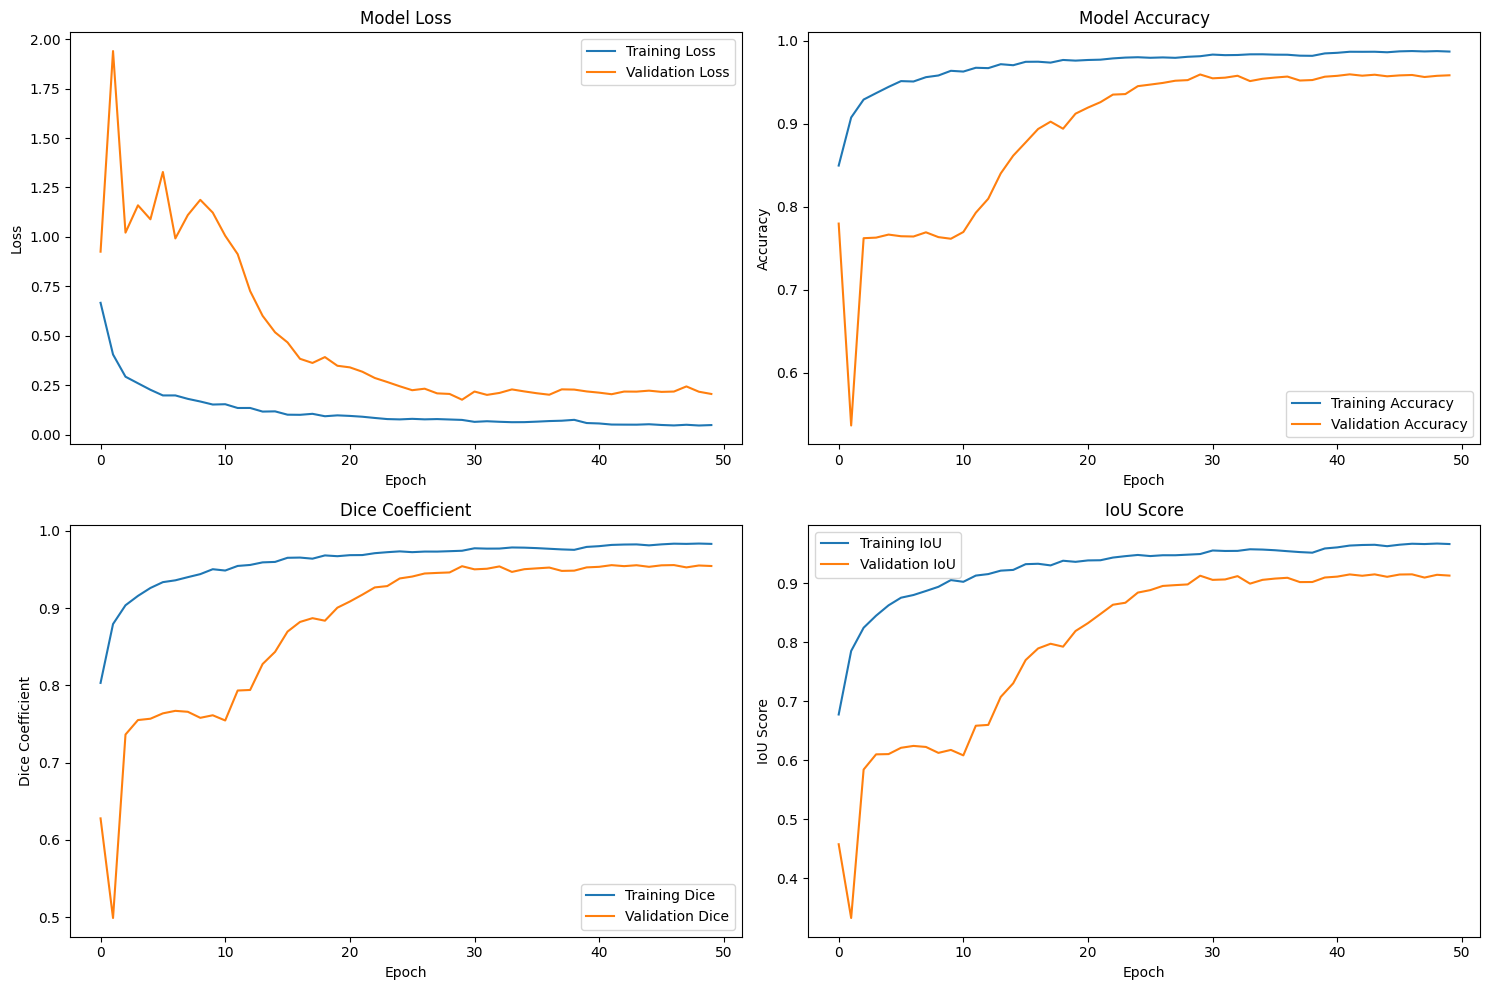

In [ ]:
plot_training_history(history)

In [ ]:

def predict_on_new_image(model, image_path):
    """Predict building segmentation on a new image"""
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_shape = image.shape[:2]

    # Create a dummy mask for the resize_with_padding function
    dummy_mask = np.zeros(original_shape, dtype=np.uint8)

    # Resize with padding to maintain aspect ratio
    image_padded, _ = resize_with_padding(image, dummy_mask, (config.IMAGE_HEIGHT, config.IMAGE_WIDTH))

    # Normalize for model input and ensure float32
    image_normalized = image_padded.astype(np.float32) / 255.0
    image_batch = np.expand_dims(image_normalized, axis=0)

    # Predict
    prediction = model.predict(image_batch)
    predicted_mask = np.argmax(prediction[0], axis=-1)

    # Remove padding and resize back to original size
    predicted_mask = remove_padding_and_resize(predicted_mask, original_shape)

    return predicted_mask

def remove_padding_and_resize(padded_mask, original_shape):
    """Remove padding and resize mask back to original image size"""
    original_h, original_w = original_shape
    target_h, target_w = config.IMAGE_HEIGHT, config.IMAGE_WIDTH

    # Calculate the scale that was used during padding
    scale = min(target_w / original_w, target_h / original_h)

    # Calculate the actual image size after scaling (before padding)
    scaled_w = int(original_w * scale)
    scaled_h = int(original_h * scale)

    # Calculate padding that was added
    pad_w = target_w - scaled_w
    pad_h = target_h - scaled_h
    pad_top = pad_h // 2
    pad_left = pad_w // 2

    # Remove padding
    unpadded_mask = padded_mask[pad_top:pad_top + scaled_h, pad_left:pad_left + scaled_w]

    # Resize back to original size
    final_mask = cv2.resize(unpadded_mask.astype(np.uint8),
                           (original_w, original_h),
                           interpolation=cv2.INTER_NEAREST)

    return final_mask

def visualize_predictions(model, dataset, save_dir, num_images=5):
    os.makedirs(save_dir, exist_ok=True)
    count = 0

    mask_save_folder = os.path.join(save_dir, "Individual Masks")
    os.makedirs(mask_save_folder, exist_ok=True)

    for batch in dataset:
        images, masks = batch
        preds = model.predict(images)
        preds = tf.argmax(preds, axis=-1).numpy()

        for i in range(images.shape[0]):
            if count >= num_images:
                return

            img = images[i]  # already a NumPy array
            print(img.shape)
            true_mask = masks[i].squeeze()  # already a NumPy array
            pred_mask = preds[i]

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(img)
            axs[0].set_title("Input Image")
            axs[0].axis("off")

            axs[1].imshow(np.argmax(true_mask, axis=-1), cmap="gray")
            axs[1].set_title("Ground Truth")
            axs[1].axis("off")

            if pred_mask.ndim == 4:
                pred_mask = pred_mask[0]

            # If pred_mask is (H, W, num_classes), convert to (H, W)
            if pred_mask.ndim == 3:
                pred_mask = np.argmax(pred_mask, axis=-1)

            mask_save_path = os.path.join(mask_save_folder, f"mask_{count}.png")
            plt.imsave(mask_save_path, pred_mask, cmap="gray")
            # Now pred_mask should be 2D
            axs[2].imshow(pred_mask, cmap="gray")
            axs[2].set_title("Predicted Mask")
            axs[2].axis("off")

            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, f"prediction_{count}.png"))


            plt.close()
            count += 1

In [ ]:
from tensorflow.keras.models import load_model

# Load best model after training
model = load_model(config.MODEL_SAVE_PATH,
                   custom_objects={
                       'dice_coefficient': dice_coefficient,
                       'iou_score': iou_score,
                       'combined_loss': combined_loss
                   })

In [ ]:
visualization_path =  "/content/drive/MyDrive/Autonomous Drone/Visualizations_Preprocessed_0722"
visualize_predictions(model, val_generator, save_dir=visualization_path, num_images=40)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


### Methodology Flow

Based on the provided notebook, the methodology flow for building segmentation is as follows:

1.  **Configuration**: Define key parameters such as image dimensions, number of classes, batch size, learning rate, dataset paths, and model save path.
2.  **Data Loading and Parsing**:
    *   Load VIA annotations from a specified JSON file.
    *   Parse the annotations to extract image filenames and corresponding polygon or rectangle coordinates.
3.  **Mask Generation**:
    *   For each image, convert the extracted annotation shapes (polygons and rectangles) into binary masks representing the building regions.
4.  **Data Splitting**:
    *   Split the image paths and generated masks into training and validation sets.
5.  **Preprocessing and Augmentation**:
    *   **Preprocessing**: For each image-mask pair:
        *   Load the image and convert it to RGB.
        *   Resize the image and mask to the target size (`config.IMAGE_HEIGHT`, `config.IMAGE_WIDTH`) while maintaining the aspect ratio using padding.
        *   Normalize the image pixels to the range \[0, 1].
        *   Convert the binary mask to a categorical mask.
    *   **Augmentation**: Apply data augmentation techniques (HorizontalFlip, RandomBrightnessContrast, RandomGamma, GaussNoise, Blur, ShiftScaleRotate) to the training data to increase dataset diversity and improve model robustness.
6.  **Data Generation**:
    *   Create a custom `DataGenerator` that handles batching, preprocessing, and augmentation of the image and mask data during training.
7.  **Model Architecture (DeepLabV3)**:
    *   Build a DeepLabV3 model with a ResNet50 backbone pre-trained on ImageNet.
    *   Utilize Atrous Spatial Pyramid Pooling (ASPP) to capture multi-scale context from high-level features.
    *   Implement a decoder to combine high-level ASPP features with low-level features from the backbone for better segmentation detail.
    *   Include Batch Normalization and Dropout layers for regularization.
8.  **Model Compilation**:
    *   Compile the model using the Adam optimizer with a specified learning rate.
    *   Define a combined loss function consisting of Categorical Crossentropy and Dice Loss.
    *   Include accuracy, Dice Coefficient, and IoU Score as evaluation metrics.
9.  **Model Training**:
    *   Train the DeepLabV3 model using the data generators.
    *   Employ callbacks such as ModelCheckpoint (to save the best model based on validation Dice Coefficient), EarlyStopping (to stop training if validation Dice Coefficient does not improve), and ReduceLROnPlateau (to reduce the learning rate when validation Dice Coefficient plateaus).
10. **Model Evaluation and Visualization**:
    *   Load the best-performing model.
    *   Visualize the training history (loss, accuracy, Dice Coefficient, IoU Score).
    *   Predict segmentation masks on new images or the validation set.
    *   Implement functions to remove padding and resize the predicted masks back to the original image dimensions for visualization.
    *   Visualize the original image, ground truth mask, and predicted mask for a set of validation images.